In [1]:
from IPython.display import HTML, display

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.
</script>''')

In [2]:
#######################################################
#         WELCOME TO HR ANALYTIC - DATA FILE          #
#######################################################
#  TO HAVE A BETTER EXPERIENCE CLICK THE BUTTON THAT  #
# SAYS 'NO TRUSTED' TO CHANGE THE STATUS TO 'TRUSTED' #
#                                                     # 
#    SELECT OPTION KERNEL --> RESTART & RUN ALL       #
#######################################################
#   CLICK THE "VOILA" BUTTON ABOVE TO RUN AS AN APP   #
#######################################################
#                                                     #
#            THANK YOU - ALEJANDRA COLACILLI          #
#                                                     #
#######################################################

In [3]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd
import os

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.tree import DecisionTreeClassifier

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Import train data and data to predict

try:
    train = pd.read_csv('https://raw.githubusercontent.com/Alecolacilli/HR_Analytics/master/general_data_total.csv')
except:
    print('File can not be opened. Please insert the training dataset file')
    
try:
    data = pd.read_csv('https://raw.githubusercontent.com/Alecolacilli/HR_Analytics_App/master/HR_Analytic_predict.csv')
except:
    data = pd.DataFrame()   

In [5]:
# Function to check and drop missing values
def find_missing_values(dataset, columns):
    if len(dataset) == 0:
        return dataset
    
    missing_values = {}
    ds_length = len(dataset)
    for column in columns:
        total_column_values = dataset[column].value_counts().sum()
        missing_values[column] = ds_length - total_column_values
        
    return missing_values

def drop_missing_values(dataset):
    if len(dataset) == 0:
        return dataset
        
    missing_vals = find_missing_values(dataset, columns=dataset.columns)
    to_drop = []
    for i in missing_vals:
        if missing_vals[i] > 0:
            to_drop.append(i)
    
    dataset = dataset.dropna(subset=to_drop)
    return dataset

train = drop_missing_values(train)
data = drop_missing_values(data)

In [6]:
# Create two new dataframes to analyze the data and compare
train_dis = pd.DataFrame() # for discretized continuous variables
data_dis = pd.DataFrame() # for discretized continuous variables

In [7]:
# Create a function to discretize the data for Marital Status with numerical values
def maritalStatus(row):
    if row.MaritalStatus == 'Married':
        return 1
    elif row.MaritalStatus == 'Single':
        return 2
    elif row.MaritalStatus == 'Divorced':
        return 3
    
# Create a function to discretize the data for Distance from Home grouping them by categories
def distance(row):
    if row.DistanceFromHome >= 0 and row.DistanceFromHome < 5:
        return 0
    elif row.DistanceFromHome >= 5 and row.DistanceFromHome < 10:
        return 1
    elif row.DistanceFromHome >= 10 and row.DistanceFromHome < 15:
        return 2
    elif row.DistanceFromHome >= 15 and row.DistanceFromHome < 20:
        return 3
    elif row.DistanceFromHome >= 20 and row.DistanceFromHome < 25:
        return 4
    elif row.DistanceFromHome >= 25 and row.DistanceFromHome < 30:
        return 5
    else:
        return 6
    
# Create a function to discretize the data for Total Working Years grouping them by categories
def work_years(row):
    if row.TotalWorkingYears >= 0 and row.TotalWorkingYears < 10:
        return 0
    elif row.TotalWorkingYears >= 10 and row.TotalWorkingYears < 20:
        return 1
    elif row.TotalWorkingYears >= 20 and row.TotalWorkingYears < 30:
        return 2
    elif row.TotalWorkingYears >= 30 and row.TotalWorkingYears <= 40:
        return 3
    else:
        return 4
    
# Create a function to discretize the data for Age grouping them by categories
def age_gen(row):
    if row.Age >= 0 and row.Age <= 21:       #Post-Millennials
        return 0
    elif row.Age >= 22 and row.Age <= 37:    #Millennials
        return 1
    elif row.Age >= 38 and row.Age <= 53:    #Generation X    
        return 2
    elif row.Age >= 54 and row.Age <= 72:    #Baby Boomers
        return 3
    else:                                    #The Silent Generation
        return 4                                                        
    
# Create a function to discretize the data for Number of Companies Worked grouping them by categories
def comp_worked(row):
    if row.NumCompaniesWorked >= 0 and row.NumCompaniesWorked < 2:      #Worked in less than 2 companies
        return 0
    elif row.NumCompaniesWorked >= 2 and row.NumCompaniesWorked < 4:    #Worked in 2 or 3 companies
        return 1
    elif row.NumCompaniesWorked >= 4 and row.NumCompaniesWorked < 6:    #Worked in 4 or 5 companies
        return 2
    elif row.NumCompaniesWorked >= 6 and row.NumCompaniesWorked < 8:    #Worked in 6 or 7 companies
        return 3
    else:                                                               #Worked in more than 8 companies
        return 4                                                        

# Create a function to discretize the data for Business Travel with numerical values
def bussTravel(row):
    if row.BusinessTravel == 'Non-Travel':
        return 0
    elif row.BusinessTravel == 'Travel_Rarely':
        return 1
    elif row.BusinessTravel == 'Travel_Frequently':
        return 2
    


In [8]:
# Unify discretized columns with one hot columns
def unify_columns(dataset):
    if len(dataset) == 0:
        return dataset
    
    # Convert to one hot
    df_job_one_hot = pd.get_dummies(dataset['JobRole'])
    df_dept_one_hot = pd.get_dummies(dataset['Department'], prefix='Dept')
    df_ed_one_hot = pd.get_dummies(dataset['EducationField'], prefix='Ed')

    # Discretized columns using above functions
    df_marStat = pd.DataFrame({'MaritalStatus': dataset.apply(maritalStatus, axis='columns')})
    df_distance = pd.DataFrame({'DistanceFromHome': dataset.apply(distance, axis='columns')})
    df_work_years = pd.DataFrame({'TotalWorkingYears': dataset.apply(work_years, axis='columns')})
    df_Age = pd.DataFrame({'Age': dataset.apply(age_gen, axis='columns')})
    df_comp_worked = pd.DataFrame({'NumCompaniesWorked': dataset.apply(comp_worked, axis='columns')})
    df_bussTravel = pd.DataFrame({'BusinessTravel': dataset.apply(bussTravel, axis='columns')})

    # Unify everythin in one dataset
    df_unify = pd.DataFrame()
    df_unify['JR_HealthRep'] = df_job_one_hot['Healthcare Representative']
    df_unify['JR_HHRR'] = df_job_one_hot['Human Resources']
    df_unify['JR_LabTec'] = df_job_one_hot['Laboratory Technician']
    df_unify['JR_Man'] = df_job_one_hot['Manager']
    df_unify['JR_MftDir'] = df_job_one_hot['Manufacturing Director']
    df_unify['JR_ResDir'] = df_job_one_hot['Research Director']
    df_unify['JR_ResSci'] = df_job_one_hot['Research Scientist']
    df_unify['JR_SaleExc'] = df_job_one_hot['Sales Executive']
    df_unify['JR_SaleRep'] = df_job_one_hot['Sales Representative']
    df_unify['MaritalStatus'] = df_marStat['MaritalStatus']
    df_unify['DistanceFromHome'] = df_distance['DistanceFromHome']
    df_unify['TotalWorkingYears'] = df_work_years['TotalWorkingYears']
    df_unify['Age'] = df_Age['Age']
    df_unify['NumCompaniesWorked'] = df_comp_worked['NumCompaniesWorked']
    df_unify['Dept_HHRR'] = df_dept_one_hot['Dept_Human Resources']
    df_unify['Dept_R&Dev'] = df_dept_one_hot['Dept_Research & Development']
    df_unify['Dept_Sales'] = df_dept_one_hot['Dept_Sales']
    df_unify['Ed_HHRR'] = df_ed_one_hot['Ed_Human Resources']
    df_unify['Ed_LifeSci'] = df_ed_one_hot['Ed_Life Sciences']
    df_unify['Ed_Mktg'] = df_ed_one_hot['Ed_Marketing']
    df_unify['Ed_Med'] = df_ed_one_hot['Ed_Medical']
    df_unify['Ed_Tech'] = df_ed_one_hot['Ed_Technical Degree']
    df_unify['Ed_Other'] = df_ed_one_hot['Ed_Other']
    df_unify['BusinessTravel'] = df_bussTravel['BusinessTravel']
    
    return df_unify

train_unify = unify_columns(train)
data_unify = unify_columns(data)


In [9]:
def fill_dataset(dataset, unified):
    if len(dataset) == 0:
        return dataset
    
    df_filled = pd.DataFrame()
      
    # Convert Gender "Female" and "Male" values to numerical values
    df_filled['Gender'] = dataset['Gender']
    df_filled['Gender'] = np.where(df_filled['Gender'] == 'Female', 1, 0) # change attrition value Male = 0 and Female = 1
    
    #Add the rest of the columns to the train and data datasets
    initial_columns = ['EmployeeID', 'MonthlyIncome', 'Man_PerformanceRating', 'PercentSalaryHike', 'JobLevel', 'Education', 'Man_JobInvolvement', 'StockOptionLevel', 'YearsAtCompany', 'Emp_EnvironmentSatisfaction', 'Emp_JobSatisfaction', 'Emp_WorkLifeBalance', 'TrainingTimesLastYear', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
    dataset_columns = ['EmployeeID', 'MonthlyIncome', 'PerformanceRating', 'PercentSalaryHike', 'JobLevel', 'Education', 'JobInvolvement', 'StockOptionLevel', 'YearsAtCompany', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'TrainingTimesLastYear', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

    #init_onehot_col = ['JobRole', 'Gender', 'MaritalStatus', 'DistanceFromHome', 'TotalWorkingYears', 'Age', 'NumCompaniesWorked', 'Department', ' EducationField', 'BusinessTravel']
    onehot_columns = ['Healthcare Representative', 'Human Resources', 'Laboratory Technician', 'Manager', 'Manufacturing Director', 'Research Director', 'Research Scientist', 'Sales Executive', 'Sales Representative', 'MaritalStatus', 'DistanceFromHome', 'TotalWorkingYears', 'Age', 'NumCompaniesWorked', 'Dept_Human Resources', 'Dept_Research & Development', 'Dept_Sales', 'Ed_Human Resources', 'Ed_Life Sciences', 'Ed_Marketing', 'Ed_Medical', 'Ed_Technical Degree', 'Ed_Other', 'BusinessTravel']
    data_onehot_col = ['JR_HealthRep', 'JR_HHRR', 'JR_LabTec', 'JR_Man', 'JR_MftDir', 'JR_ResDir', 'JR_ResSci', 'JR_SaleExc', 'JR_SaleRep', 'MaritalStatus', 'DistanceFromHome', 'TotalWorkingYears', 'Age', 'NumCompaniesWorked', 'Dept_HHRR', 'Dept_R&Dev', 'Dept_Sales', 'Ed_HHRR', 'Ed_LifeSci', 'Ed_Mktg', 'Ed_Med', 'Ed_Tech', 'Ed_Other', 'BusinessTravel']

    
    df_filled[dataset_columns] = dataset[initial_columns]
    df_filled[data_onehot_col] = unified[data_onehot_col]
    
    return df_filled

train_dis = fill_dataset(train, train_unify)
data_dis = fill_dataset(data, data_unify)

# Convert attrition "Yes" and "No" values to numerical values and add to the train dataset
train_dis['Attrition'] = train['Attrition']
train_dis['Attrition'] = np.where(train_dis['Attrition'] == 'Yes', 1, 0) # change attrition value No = 0 and Yes = 1

In [10]:
# Save the clean dataset in a csv file
train_dis.to_csv('HR_Analytic_to_train.csv', index=False)
data_dis.to_csv('HR_Analytic_to_predict.csv', index=False)

In [11]:
# Split the dataframe into data and labels
X_axis = train_dis.drop('Attrition', axis=1) # This will be the data
y_axis = train_dis.Attrition # This will be the labels

In [12]:
# The selected algorithm will be the Decision tree Classifier
# Split the dataset for train and test using the best random split

decision = tree.DecisionTreeClassifier(criterion='gini')
X = X_axis.values
Y = y_axis.values
indices = X_axis['EmployeeID']
X_train, X_test, Y_train, Y_test, Index_train, Index_test = train_test_split(X, Y, indices, test_size=0.25, random_state = 4)

# Train the model
decision.fit(X_train, Y_train)

# Make a prediction with the test data
y_pred = decision.predict(data_dis)

<h1 style="text-align: center;"><span style="color: #ff9900;">Prediction</span></h1>

<h3>After the evaluation of different data analytics algorithms, we choose the Decision Tree Classifier because of the performance and accuracy provided.<h3>

<h2 style="text-align: left;"><span style="color: #ff9900;">Most relevant information</span></h2>
<h3>Following you will see the most relevant attributes when it comes to deciding whether to stay or leave the company:<h3>

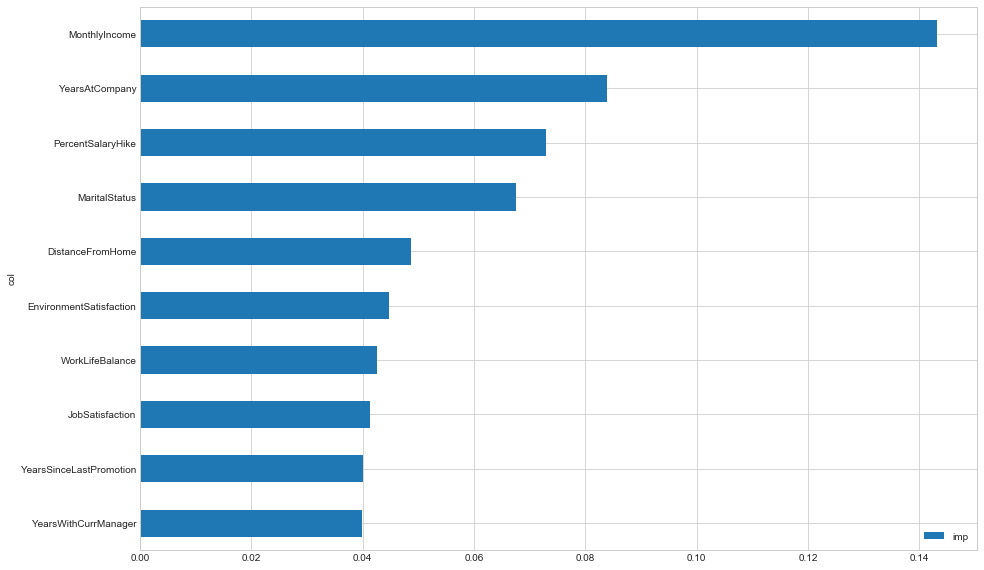

In [13]:
# DataFrame column importance
def data_importance(algorithm, data):       
    fea_imp = pd.DataFrame({'imp': algorithm.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, True]).iloc[-10:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(15, 10))

    #return fea_imp


# Plot the feature importance scores

        
data_importance(decision, X_axis)

<h2 style="text-align: left;"><span style="color: #ff9900;">Predicted Data</span></h2>

We can conclude this evaluation with the analysis of the predictions.
Below you will find some graphs and interactive querys that will help you to understand how those attributes could affect on each employee decition to leave the company

<h2>Prediction: Are the employees leaving the company?</h2>

No     39
Yes    11
Name: Leave_Company, dtype: int64


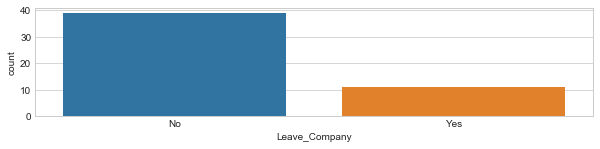

In [14]:
presentation = pd.DataFrame()

presentation['EmployeeID'] = data_dis['EmployeeID']
presentation['Leave_Company'] = y_pred
presentation['Leave_Company'] = np.where(presentation['Leave_Company'] == 1, 'Yes', 'No') # change attrition value No = 0 and Yes = 1  

fig, (ax1) = plt.subplots(figsize=(10,2))
ax1 = sns.countplot(x='Leave_Company', data=presentation, ax=ax1)
print(presentation.Leave_Company.value_counts())
presentation = presentation.sort_values(by='EmployeeID', ascending=True)

In [15]:
df_plot = pd.DataFrame()
df_plot['Leave_Company'] = presentation['Leave_Company'] 

for i in data_dis:
    df_plot[i] = data_dis[i]

qgrid_plot = pd.DataFrame()
qgrid_plot['ID']=df_plot['EmployeeID']
qgrid_plot['Leave_Company']=df_plot['Leave_Company']
qgrid_plot['Gender']=df_plot['Gender']
qgrid_plot['Age']=df_plot['Age']
qgrid_plot['Marital ST']=df_plot['MaritalStatus']
qgrid_plot['Income']=df_plot['MonthlyIncome']
qgrid_plot['Salary Hike']=df_plot['PercentSalaryHike']
qgrid_plot['Yrs at Co.']=df_plot['YearsAtCompany']
qgrid_plot['Yrs since promo']=df_plot['YearsSinceLastPromotion']
qgrid_plot['Env Satis']=df_plot['EnvironmentSatisfaction']
qgrid_plot['WorkLifeBalance']=df_plot['WorkLifeBalance']
qgrid_plot['Job Satis']=df_plot['JobSatisfaction']
qgrid_plot['No. Co. Worked']=df_plot['NumCompaniesWorked']
qgrid_plot['Education']=df_plot['Education']


<h3>The following table shows the prediction made by each employee and the most important factors evaluated:</h3>

In [16]:
from IPython.display import HTML, display
import qgrid

col_defs = {
    'ID': {
        'width': 35
    },
    'Marital ST': {
        'width': 80
    },
    'Salary Hike': {
        'width': 85
    },
    'Years in Co.': {
        'width': 85
    },
    'Yrs since promo': {
        'width': 85
    },
    'WorkLifeBalance': {
        'width': 85
    },
    'No. Co. Worked': {
        'width': 85
    }
    
}

df_widget = qgrid.show_grid(qgrid_plot, show_toolbar=True, column_definitions=col_defs, grid_options={
    # SlickGrid options
    'fullWidthRows': True,
    'syncColumnCellResize': False,
    'forceFitColumns': False,
    'defaultColumnWidth': 65,
    'rowHeight': 25,
    'enableColumnReorder': False,
    'enableTextSelectionOnCells': True,
    'editable': False,
    'autoEdit': False,
    'explicitInitialization': True,
    'filter_dropdown_shown': True,

    # Qgrid options
    'maxVisibleRows': 15,
    'minVisibleRows': 8,
    'sortable': True,
    'filterable': True,
    'highlightSelectedCell': False,
    'highlightSelectedRow': True},
    
    column_options={
    # SlickGrid column options
    'defaultSortAsc': True,
    'maxWidth': 200,
    'minWidth': 10,
    'resizable': True,
    'sortable': True,
    'toolTip': "",
    'width': None
})
df_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': False, 'forceFitColumns': False, 'def…

<h3>We can conclude that there is more than one factor that motivates an employee to consider leaving the company.</h3>

<h2 style="text-align: left;"><span style="color: #ff9900;">Graphs</span></h2>

<h3>The following graphs shows the relationship between the different factos and the probability that one person stays or leave the company<h3>
<h3>Attributes References:</h3>
<h3>Gender</h3>
<li>0 = Male</li>
<li>1 = Female</li>

<h3>Age Generation</h3>
<li>0 = Post-Millennials (0-21 Yrs old)</li>
<li>1 = Millennials (22-37 Yrs old)</li>
<li>2 = Generation X (38-53 Yrs old)</li>
<li>3 = Baby Boomers (54-72 Yrs old)</li>
<li>4 = The Silent Generation (+72 Yrs old)</li>

<h3>Marital Status</h3>
<li>1 = Married</li>
<li>2 = Single</li>
<li>3 = Divorced</li>

<h3>Env. Satisfaction:</h3>
<li>1 = 'Low'</li>
<li>2 = 'Medium'</li>
<li>3 = 'High'</li>
<li>4 = 'Very High'</li>
    
<h3>Emp_WorkLifeBalance</h3>
<li>1 = 'Bad'</li>
<li>2 = 'Good'</li>
<li>3 = 'Better'</li>
<li>4 = 'Best'</li>

<h3>Job Satisfaction</h3>
<li>1 = 'Low'</li>
<li>2 = 'Medium'</li>
<li>3 = 'High'</li>
<li>4 = 'Very High'</li>

<h3>Education<h3>
<li>1 = Below College</li>
<li>2 = College</li>
<li>3 = Bachelor</li>
<li>4 = Master</li>
<li>5 = Doctor</li>

<h3> Relationship with Salary and Company Environment

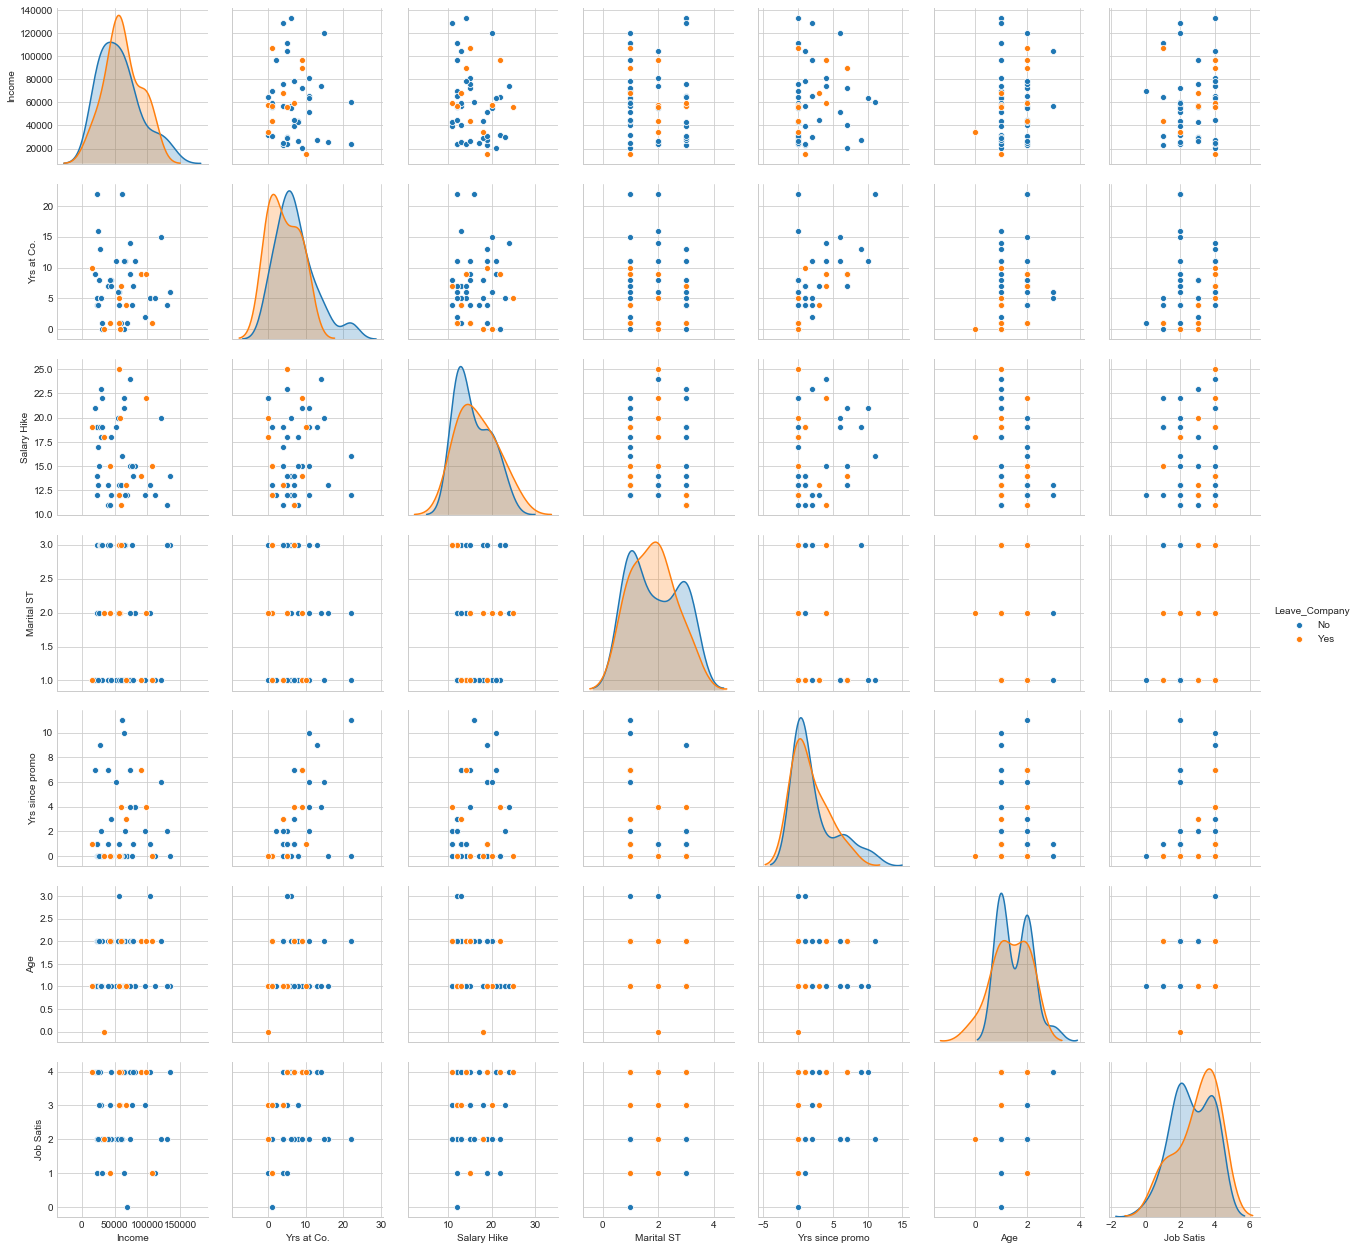

In [17]:
sns.pairplot(qgrid_plot, hue='Leave_Company', vars=["Income", "Yrs at Co.", "Salary Hike", "Marital ST", "Yrs since promo", "Age", "Job Satis"])

<h3>Relationship with the mployee satisfaction</h3>

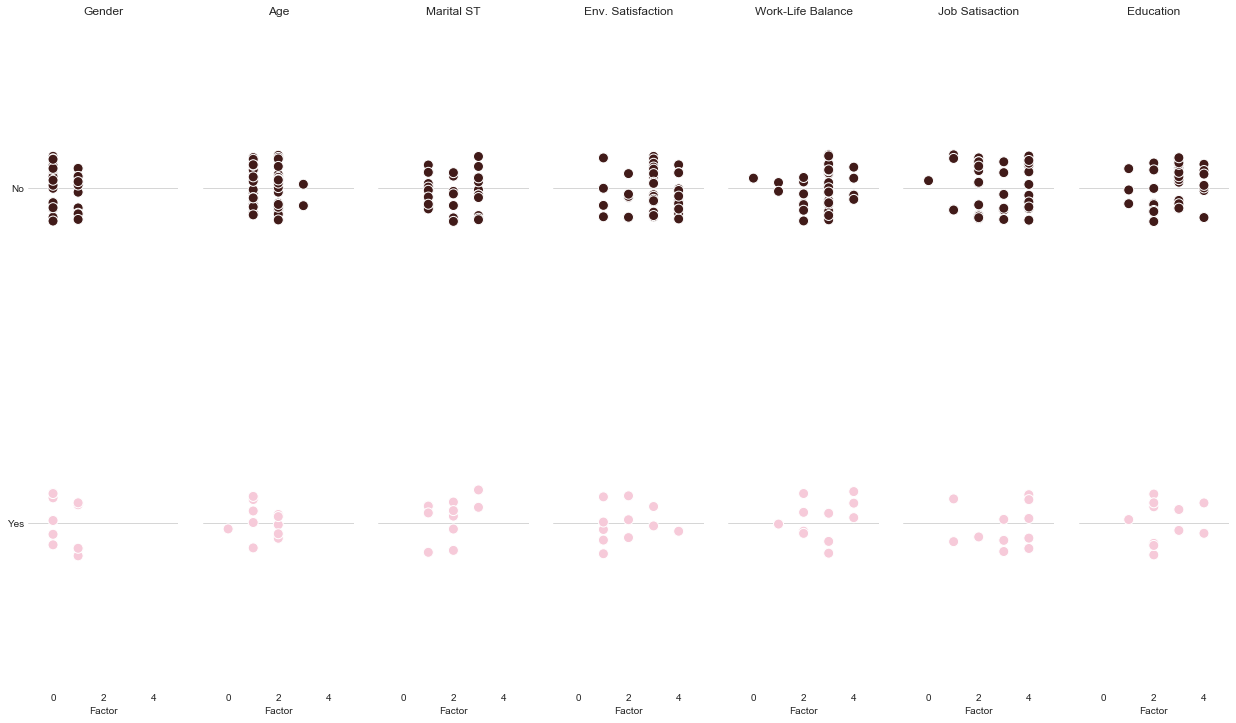

In [18]:
g = sns.PairGrid(qgrid_plot,
                 x_vars=["Gender", "Age", "Marital ST", "Env Satis", "WorkLifeBalance", "Job Satis", "Education"], y_vars=["Leave_Company"],
                 height=10, aspect=.25)

g.map(sns.stripplot, size=10, orient="h",
      palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")

g.set(xlim=(-1, 5), xlabel="Factor", ylabel="")

titles = ["Gender", "Age", "Marital ST", "Env. Satisfaction", "Work-Life Balance", "Job Satisaction", "Education"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

<h3>Monthly Income</h3>

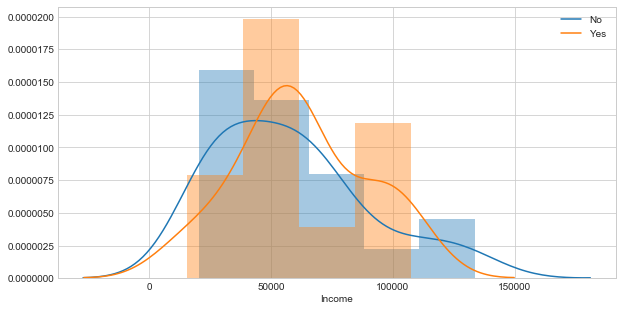

In [19]:
# How does the Monthly Income looks compared to Attrition?
fig = plt.figure(figsize=(10, 5))
sns.distplot(qgrid_plot.loc[qgrid_plot['Leave_Company'] == ('No')]['Income'], kde_kws={'label': 'No'});
sns.distplot(qgrid_plot.loc[qgrid_plot['Leave_Company'] == ('Yes')]['Income'], kde_kws={'label': 'Yes'});

<h3>Marital Status<h3>

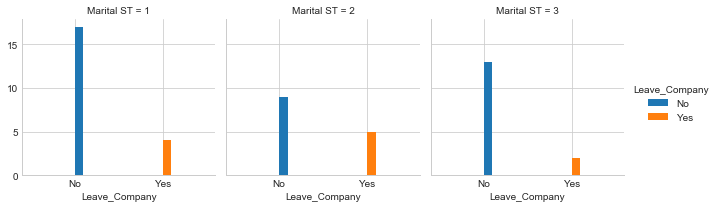

In [20]:
g = sns.FacetGrid(qgrid_plot, col="Marital ST", hue="Leave_Company")
g.map(plt.hist, "Leave_Company", alpha=1);
g.add_legend();